# [实验五报告](https://github.com/YuweiWen1217/2024-MachineLearning)
文昱韦 2213125

### 实验五：层次聚类
1. **初级要求**：自行生成数据集，包含2000个样例，每个样例的前3列表示特征，第4列表示标签。实现single-linkage层次聚类算法；实现complete-linkage层次聚类算法。
2. **中级要求**：实现average-linkage层次聚类算法；将上述三种算法的性能进行简要对比。
3. **高级要求**：通过变换聚类簇的个数，测试上述三种算法的性能，并给出分析。

### 初级要求

#### 数据集的生成

为了测试不同聚类算法的性能，我们通过`sklearn`提供的 `make_blobs` 函数生成了一个模拟数据集。本实验中，我们设定了以下参数：

- **簇的中心点**：`centers=[[1,1,1], [1,3,3], [3,6,5], [2,6,8]]`，共有 4 个中心点，表示生成的数据点分布在三维空间内。
- **总样本数**：`num=2000`，表示总共生成 200 个数据点。
- **簇的离散程度**：`std=0.6`，表示每个簇的数据点围绕中心点的标准差。

由此，每个样本在三维空间内的坐标，即是它的特征，它所属的类别是它的标签。

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import adjusted_rand_score

In [2]:
def create_data(centers, num = 2000, std = 0.6):
    X, labels_true = make_blobs(n_samples=num, centers=centers, cluster_std=std)
    return  X,labels_true

centers=[[1,1,1], [1,3,3], [3,6,5], [2,6,8]]
X, labels_true= create_data(centers)

# 如需要保存至文件中，可以启用下面两行代码
# np.savetxt('X.txt',X)
# np.savetxt('y.txt',labels_true)
print("generate data finish!")

generate data finish!


我们使用 Matplotlib 绘制数据集图像，如图所示：

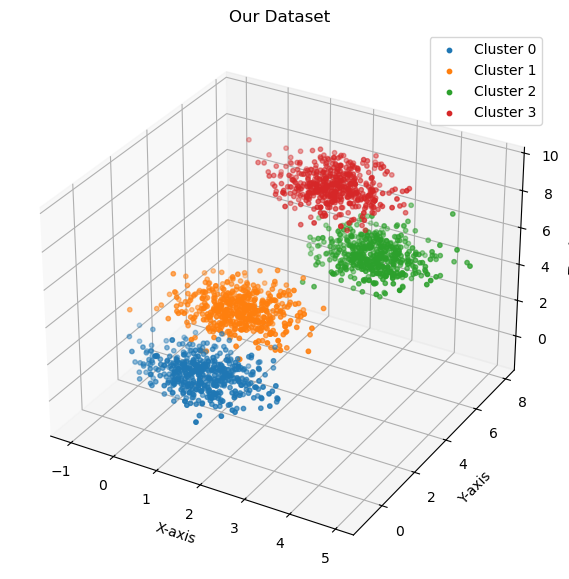

In [3]:
# 绘制生成的三维数据点
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for label in set(labels_true):
    cluster_points = X[labels_true == label]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {label}', s=10)
ax.set_title("Our Dataset")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.legend()
plt.show()

#### 聚类过程概述

本实验采用的是**聚合聚类**算法，属于层次聚类的一种，是一种**自底向上**的聚类方法，其主要思想是从每个数据点开始，将每个点视为一个独立的类，逐步合并距离最近的簇，直到达到预定的类数（本实验中，要将所有的点分为4类）为止。大致方法如下：

1. **初始化距离矩阵和类间矩阵**：将每个数据点视为单独的类，即每个类只包含一个点。因此，我们要计算数据集中每一对点之间的距离，并存储在距离矩阵 `allDist` 中。此处的距离采用欧几里得距离的平方：  
   $$
   d_{ij} = \sum_{k=1}^{n} (x_{ik} - x_{jk})^2
   $$
   我们可以通过将距离矩阵直接赋值给类间矩阵`clusterDist`实现初始化，唯一不同的是，对角线上的值要从0改为无穷大。

2. **类合并**：在每次迭代中，我们从类间矩阵中选择距离最近的两个类进行合并。合并后，更新合并后的类与其他类之间的距离（即本实验探讨的单链法、全链法等不同策略），并调整类间矩阵。

3. **停止条件**：直至剩余的类数为4时，停止合并。

In [4]:
MAX_NUM = 1e3
class AgglomerativeClustering:
    def __init__(self, k=None, isaverageLinkage=False):
        self.k = k
        self.isaverageLinkage = isaverageLinkage  # 新增成员变量，默认值为False
        self.steps = []  # 用于记录聚类过程中的合并步骤，每次合并记录两个簇的代表点索引。

    def fit(self, datas, method):
        """
        执行层次聚类的核心方法。
        :param datas: 数据集，形状为 (n_samples, n_features) 的 numpy 数组。
        :param method: 函数对象，用于计算两个簇之间的距离（如 single-linkage, complete-linkage 等）。
        """
        self.dataCnt = datas.shape[0]  # 数据点的数量
        allDist = np.zeros((self.dataCnt, self.dataCnt))  # 存储所有数据点之间的距离矩阵

        # 计算每对点之间的欧式距离平方，填充到距离矩阵中
        for i in range(self.dataCnt):
            for j in range(i):
                allDist[i][j] = allDist[j][i] = np.sum((datas[i] - datas[j]) ** 2)
        setList, clusterCount = [[i] for i in range(self.dataCnt)], self.dataCnt  # 初始化每个点为独立簇 

        # 初始化簇间距离矩阵，初始值为无穷大
        clusterDist = np.zeros((self.dataCnt, self.dataCnt)) + MAX_NUM
        for i in range(clusterCount):
            for j in range(i + 1, clusterCount):
                clusterDist[i][j] = clusterDist[j][i] = allDist[i][j]  # 初始的簇间距离等于数据点之间的距离

        # 聚类过程，直到剩余的簇数量为 4（可以根据需要调整停止条件）
        while clusterCount != self.k:
            # 找到当前簇间距离矩阵中距离最小的两个簇
            res = np.argmin(clusterDist)  # 获取最小值的索引
            dest, src = int(res / clusterCount), res % clusterCount  # 将索引转为矩阵中的行、列（簇编号）
            self.steps.append((setList[dest][0], setList[src][0]))  # 记录本次合并的两个簇

            # 根据 `method` 函数更新合并后的簇与其他簇的距离
            if self.isaverageLinkage:
                modify = method(clusterDist[[dest, src]], len(setList[dest]),len(setList[src])) 
            else:
                 modify = method(clusterDist[[dest, src]])
            clusterDist[dest] = modify  # 更新合并后簇的行
            clusterDist[:, dest] = modify  # 更新合并后簇的列
            clusterDist = np.delete(clusterDist, src, axis=0)  # 删除被合并簇的行
            clusterDist = np.delete(clusterDist, src, axis=1)  # 删除被合并簇的列
            clusterDist[dest][dest] = MAX_NUM  # 设置自身距离为无穷大

            # 更新簇集合，将被合并簇的点加入合并后的簇
            setList[dest] = setList[dest] + setList[src]
            del setList[src]  # 删除被合并的簇
            clusterCount -= 1  # 更新簇的总数
        print("Cluster Result: ") 
        for i, cluster in enumerate(setList):
            print(f"  Cluster {i} has {len(cluster)} samples")
        

    def label(self, k):
        """
        根据合并记录生成簇标签。

        :param k: 指定最终聚类结果中的簇数量。
        :return: 簇标签列表，每个数据点对应一个簇标签。
        """
        root = list(range(self.dataCnt))  # 初始化每个点为自身的根节点

        def find_root(n):
            """
            找到节点 n 的根节点，并执行路径压缩。
            """
            if root[root[n]] == root[n]:
                return root[n]  # 当前节点的父节点即为根节点
            root[n] = find_root(root[n])  # 路径压缩，将节点直接连接到根节点
            return root[n]

        # 根据记录的合并步骤更新根节点
        for i in range(self.dataCnt - k):  # 仅执行 (dataCnt - k) 次合并，保留 k 个簇
            src, dest = self.steps[i]
            root[find_root(dest)] = find_root(src)  # 将一个簇的根节点合并到另一个簇

        # 分配簇标签
        cluster, clusterNum = [0 for _ in range(self.dataCnt)], 0
        for i in range(self.dataCnt):
            if i == root[i]:  # 当前节点是根节点，分配新的簇编号
                clusterNum += 1
                cluster[i] = clusterNum
        for i in range(self.dataCnt):
            if i != root[i]:  # 非根节点继承其根节点的簇编号
                cluster[i] = cluster[find_root(i)]
        return cluster
    
def plot_data(*data):
    X, labels_true, labels_predict = data
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    colors = 'rgbyckm'
    markers = 'o^sP*DX' 
    for i in range(len(labels_true)):
        ax.scatter(
            X[i, 0], X[i, 1], X[i, 2], 
            label="cluster %d" % labels_true[i],
            color=colors[labels_true[i] % len(colors)],
            marker=markers[labels_predict[i] % len(markers)],
            alpha=0.5 
        )
    ax.set_title("Clustering Results")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    #plt.legend()
    plt.show()


#### Single-Linkage
两个类之间的距离由类间的最短距离决定。即，合并的新类与类A的距离是原两个类到类A距离中的较小者。
$$
d_{\text{new}, k} = \min(d_{i, k}, d_{j, k})
$$
其中 $i$ 和 $j$ 是两个被合并的类，$k$是其他类。

这种方法强调局部最近的点，适合捕捉非凸形状的簇，但可能导致**链式效应**（过分拉长的类）。  

例如，我们有下面的例子
$$
\begin{array}{c|c|c|c}
  & A & B & C \\
\hline
A & ∞ & 2 & 5 \\
B & 2 & ∞ & 4 \\
C & 5 & 4 & ∞ \\
\end{array}
$$

我们从中找到最小值是2，对应$A$ 和$B$，然后计算新类 $AB$ 与 $C$ 的距离，取距离$|AC|$和$|BC|$中的较小者，结果是4。  于是，新的距离矩阵为：
$$
\begin{array}{c|c|c}
  & AB & C \\
\hline
AB & 0 & 4 \\
C  & 4 & 0 \\
\end{array}
$$

In [5]:
# 传入的参数是两行n列的矩阵，返回一行n列的矩阵
k = 4
def singleLinkage(cluster_distances):
    return np.min(cluster_distances, axis=0)
method = singleLinkage
model = AgglomerativeClustering(k=k)
model.fit(X, method)

Cluster Result: 
  Cluster 0 has 1997 samples
  Cluster 1 has 1 samples
  Cluster 2 has 1 samples
  Cluster 3 has 1 samples


由聚类结果可知，大部分样本被合并到一个大的类中，这也表明了单链法对相对距离非常敏感，这个类的形成是正常的，尤其在没有足够大的“跳跃距离”的情况下。

下面，我们对聚类结果进行两项分析：
1. 我们将聚类结果绘图，其中不同颜色代表样本的真实类别，不同形状代表样本的聚类类别。
2. 我们使用**调整兰德指数**（**Adjusted Rand Index, ARI**）来评估单链法的性能，ARI的值在[-1, 1]之间，值越大表示聚类结果与真实标签越一致，值为0表示聚类结果与真实标签的一致性与随机聚类相当，值为负则表示聚类结果比随机聚类还差。

ARI: -0.0000010005


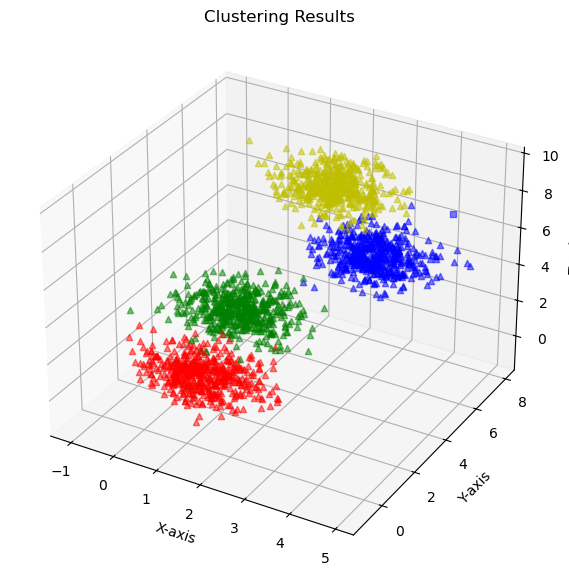

In [6]:
labels_predict = model.label(k)
ari1 = adjusted_rand_score(labels_true, labels_predict)
print(f"ARI: {ari1:.10f}")
plot_data(X, labels_true, labels_predict)

由于几乎全部样本都被分到了一个类中，因此性能指标ARI甚至为负值，图中也可以看出，几乎所有点都是三角形。

#### Complete-Linkage
两个类之间的距离由类间的最长距离决定。即，合并的新类与类A的距离是原两个类到类A距离中的较大者。
$$
d_{\text{new}, k} = \max(d_{i, k}, d_{j, k})
$$
其中 $i$ 和 $j$ 是两个被合并的类，$k$是其他类。

这种方法强调全局的聚合性，能生成紧凑的类，但对噪声较为敏感。

Cluster Result: 
  Cluster 0 has 435 samples
  Cluster 1 has 478 samples
  Cluster 2 has 567 samples
  Cluster 3 has 520 samples
ARI: 0.8814113354


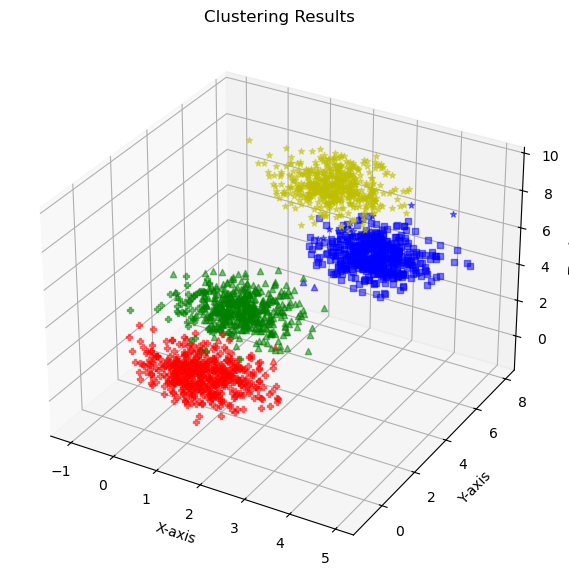

In [7]:
def completeLinkage(cluster_distances):
    return np.max(cluster_distances, axis=0)
method = completeLinkage
model = AgglomerativeClustering(k=4)
model.fit(X, method)

labels_predict = model.label(k)
ari2 = adjusted_rand_score(labels_true, labels_predict)
print(f"ARI: {ari2:.10f}")
plot_data(X, labels_true, labels_predict)

由图可以看出，除了绿、红两类的交界处，以及蓝、黄两类的交界处，有部分样本发生错误外，其他样本都被很好的归为了对应类别，并且单链法中的极端现象也不复存在。

### 中级要求

#### Average-Linkage
两个类之间的距离由类间的最长距离决定。即，合并的新类与类A的距离是原两个类到类A距离中的较大者。
$$
d_{\text{new}, k} = \frac{ m\times d_{i, k} + n\times d_{j, k}}{m+n}
$$
其中 $i$ 和 $j$ 是两个被合并的类，$k$是其他类，$m$和$n$分别是$i$和$j$中的样本数。

Cluster Result: 
  Cluster 0 has 506 samples
  Cluster 1 has 500 samples
  Cluster 2 has 496 samples
  Cluster 3 has 498 samples
ARI: 0.9631079907


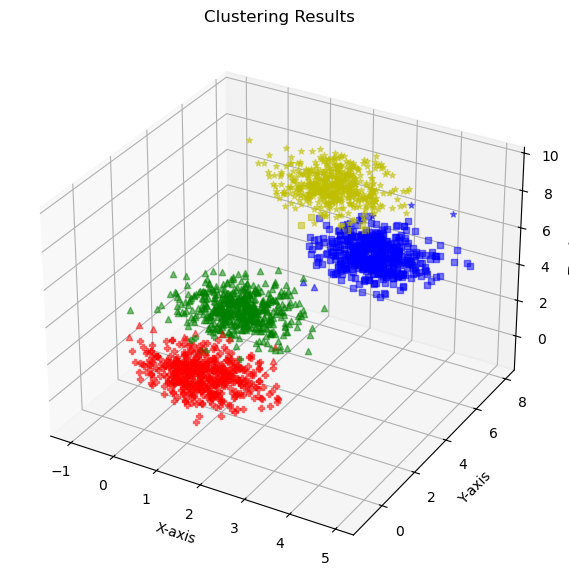

In [8]:
def averageLinkage(cluster_distances, m, n):
    new_distances = (m * cluster_distances[0] + n * cluster_distances[1]) / (m + n)
    return new_distances
method = averageLinkage
model = AgglomerativeClustering(k=4, isaverageLinkage=True)
model.fit(X, method)

labels_predict = model.label(k)
ari3 = adjusted_rand_score(labels_true, labels_predict)
print(f"ARI: {ari3:.10f}")
plot_data(X, labels_true, labels_predict)

和之前的完全链接法一样，绿、红两类的交界处，以及蓝、黄两类的交界处，也有少量样本发生错误。但从ARI上可以看出，该方法比完全链接法性能更好。

#### 性能对比
我们使用**调整兰德指数**（**Adjusted Rand Index, ARI**）来评估单链法的性能，ARI的值在[-1, 1]之间，值越大表示聚类结果与真实标签越一致，值为0表示聚类结果与真实标签的一致性与随机聚类相当，值为负则表示聚类结果比随机聚类还差。

- single-linkage: -0.0000

- complete-linkage: 0.8814

- average-linkage: 0.9631

通过这些结果可以看出，均值链接法的性能最好，几乎完美地匹配了真实标签。而完全链接法也表现较好，适用于需要较高聚类精度的场景。相比之下，单链法的性能非常弱，特别是不同类的中心相隔较近，类内离散度较大等情况时表现不佳。

### 高级要求
刚刚，我们使用的聚类簇的个数是4。下面，我们在保持每个类的真实样本数为500的情况下，进行不同类簇数（2~6）下不同层次聚类方法的性能比较分析。对于每个聚类的中心点，我们采取随机数生成的方式，让中心点的每个坐标在0~10之间。性能指标依旧使用调整兰德指数（ARI）。

当前聚类数：2
当前方法：singleLinkage
Cluster Result: 
  Cluster 0 has 500 samples
  Cluster 1 has 500 samples
当前方法：completeLinkage
Cluster Result: 
  Cluster 0 has 500 samples
  Cluster 1 has 500 samples
当前方法：averageLinkage
Cluster Result: 
  Cluster 0 has 500 samples
  Cluster 1 has 500 samples

当前聚类数：3
当前方法：singleLinkage
Cluster Result: 
  Cluster 0 has 999 samples
  Cluster 1 has 500 samples
  Cluster 2 has 1 samples
当前方法：completeLinkage
Cluster Result: 
  Cluster 0 has 500 samples
  Cluster 1 has 500 samples
  Cluster 2 has 500 samples
当前方法：averageLinkage
Cluster Result: 
  Cluster 0 has 500 samples
  Cluster 1 has 500 samples
  Cluster 2 has 500 samples

当前聚类数：4
当前方法：singleLinkage
Cluster Result: 
  Cluster 0 has 999 samples
  Cluster 1 has 500 samples
  Cluster 2 has 500 samples
  Cluster 3 has 1 samples
当前方法：completeLinkage
Cluster Result: 
  Cluster 0 has 514 samples
  Cluster 1 has 500 samples
  Cluster 2 has 500 samples
  Cluster 3 has 486 samples
当前方法：averageLinkage
Cluster Result: 
 

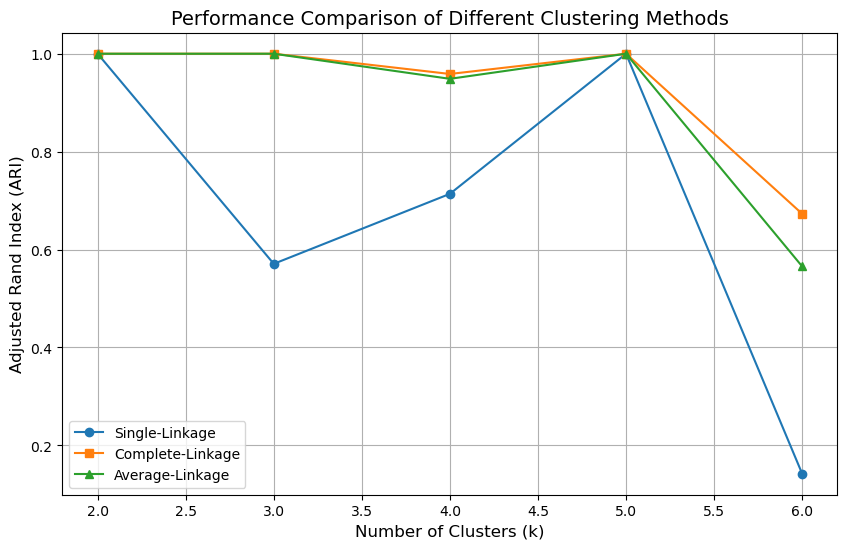

In [9]:
METHOD_APPLY = [singleLinkage, completeLinkage, averageLinkage]

k_values = [2, 3, 4, 5, 6] 
ari_single_k = []
ari_complete_k = []
ari_average_k = []

for k in k_values:
    centers = np.random.rand(k, 3) * 10  # 随机生成k个聚类中心
    X, labels_true = create_data(centers, num=k*500)
    print(f"当前聚类数：{k}")
    for method in METHOD_APPLY:
        print(f"当前方法：{method.__name__}")
        if method == averageLinkage:
            model = AgglomerativeClustering(k=k, isaverageLinkage=True)
        else:
            model = AgglomerativeClustering(k=k)
        model.fit(X, method)
        labels_predict = model.label(k)
        ari = adjusted_rand_score(labels_true, labels_predict)
        if method == singleLinkage:
            ari_single_k.append(ari)
        elif method == completeLinkage:
            ari_complete_k.append(ari)
        elif method == averageLinkage:
            ari_average_k.append(ari)
    print()

# 绘制不同聚类数下的ARI变化
plt.figure(figsize=(10, 6))
plt.plot(k_values, ari_single_k, label='Single-Linkage', marker='o')
plt.plot(k_values, ari_complete_k, label='Complete-Linkage', marker='s')
plt.plot(k_values, ari_average_k, label='Average-Linkage', marker='^')

plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Adjusted Rand Index (ARI)', fontsize=12)
plt.title('Performance Comparison of Different Clustering Methods', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
    

根据结果可以看出：聚类数较小，如$k=2$，三种方法的表现均较好；随着聚类数的增大，单链法由于其自身的局限性和样本分布确实比较靠近的事实，从而表现出明显的劣势；其余两种方法性能几乎相近，再个别情况下，如$k=4$和$k=6$时，均值链接法要比完全链接法更好。

对于$k=5$时，应该是五个样本中心相隔均较远，因此三种层次聚类方法的差异不明显；相对应的是$k=6$的这种情况，应该是某几个样本中心较近，导致三种方法的性能都有所下降，当然，这也更能看出平均链接法的优越之处。